In [1]:
!pip install --upgrade datasets
!rm -rf ~/.cache/huggingface/datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

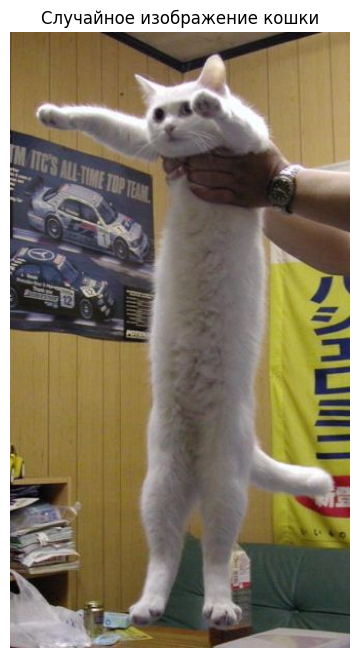

Предсказанный класс: llama


In [3]:
!pip install -q transformers torch pillow requests

from transformers import AutoImageProcessor, SwinForImageClassification
import torch
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import random
import time

# Инициализация модели и процессора
model = SwinForImageClassification.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224"
)
image_processor = AutoImageProcessor.from_pretrained(
    "microsoft/swin-tiny-patch4-window7-224"
)

def get_random_cat_image():
    """Загружает случайное изображение кошки с различных API"""
    sources = [
        # Случайные картинки
        lambda: requests.get("https://cataas.com/cat", timeout=10).content,

        lambda: requests.get("https://api.thecatapi.com/v1/images/search", timeout=10).json()[0]['url'],

        lambda: requests.get(f"https://placekitten.com/{random.randint(300, 800)}/{random.randint(300, 800)}", timeout=10).content,

        lambda: requests.get("https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg", timeout=10).content
    ]

    for source in random.sample(sources, len(sources)):
        try:
            if callable(source):
                content = source()
                if isinstance(content, str):  # Если получили URL
                    content = requests.get(content, timeout=10).content
                return Image.open(BytesIO(content))
        except Exception as e:
            print(f"Ошибка загрузки: {e}, пробуем другой источник...")
            time.sleep(1)


    from PIL import ImageDraw
    img = Image.new('RGB', (224, 224), color=(73, 109, 137))
    draw = ImageDraw.Draw(img)
    draw.text((10, 10), "Random Cat Placeholder", fill=(255, 255, 0))
    return img

# Загрузка случайного изображения кошки
image = get_random_cat_image()

# Отображение изображения
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title("Случайное изображение кошки")
plt.show()

# Обработка и предсказание
inputs = image_processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label_id = logits.argmax(-1).item()
predicted_label_text = model.config.id2label[predicted_label_id]

print(f"Предсказанный класс: {predicted_label_text}")